In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/project1/

/content/drive/My Drive/project1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score , precision_score , confusion_matrix, accuracy_score
import tensorflow as tf
import time
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

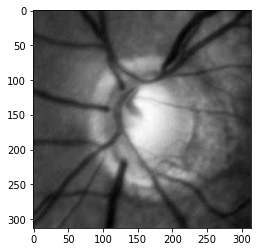

In [ ]:
DATADIR = "datasets"

CATEGORIES = ["Glaucoma", "Non Glaucoma"]

for category in CATEGORIES:  # do glaucoma and non glaucoma
    path = os.path.join(DATADIR,category)  # create path to glaucoma and non glaucoma
    for img in os.listdir(path):  # iterate over each image per glaucoma and non glaucoma
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [ ]:
training_data = []
IMG_SIZE = 150

def create_training_data():
    for category in CATEGORIES:  # do glaucoma and non glaucoma

        path = os.path.join(DATADIR,category)  # create path to glaucoma and non glaucoma
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=glaucoma 1=non glaucoma

        for img in tqdm(os.listdir(path)):  # iterate over each image per glaucoma and non glaucoma
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 309/309 [00:06<00:00, 50.20it/s] 

705


In [ ]:
import random

random.shuffle(training_data)

In [ ]:
for sample in training_data[:10]:
    print(sample[1])

1
1
0
0
1
1
0
1
1
0


In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[116]
   [116]
   [113]
   ...
   [110]
   [110]
   [109]]

  [[121]
   [120]
   [115]
   ...
   [109]
   [109]
   [112]]

  [[119]
   [115]
   [119]
   ...
   [108]
   [109]
   [112]]

  ...

  [[109]
   [115]
   [119]
   ...
   [124]
   [122]
   [117]]

  [[111]
   [114]
   [118]
   ...
   [121]
   [119]
   [115]]

  [[112]
   [116]
   [117]
   ...
   [120]
   [117]
   [116]]]]


In [ ]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y)
X = X/255.0

In [ ]:
# Preserve State to compare parameter tuning 
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=rand_state)


In [ ]:
X_train[0].shape

(150, 150, 1)

In [ ]:
print(X.shape[1:])

(150, 150, 1)


In [ ]:
# Creating the Model 

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape= X.shape[1:]))
feature_extractor.add(Conv2D(64, (3, 3), activation='relu'))
feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))
feature_extractor.add(Dropout(0.25))
feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = 'relu', kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(1, activation = 'sigmoid')(x)

In [ ]:
from keras.models import Model, Sequential
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                             

In [ ]:
# Check the training time for the cnn
t=time.time()

cnn_model.fit(X_train, y_train,
          batch_size=128,
          epochs=40,
          verbose=1,
          validation_data=(X_test, y_test))
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train cnn')

# Prediction 
# Check the prediction time for a single sample
t=time.time()
y_pred = cnn_model.predict(X_test)
t2 = time.time()
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
print(round(t2-t, 5), 'Seconds to predict','labels with cnn')

# Check the score of the cnn
print('Test Accuracy of cnn = ',accuracy_score(y_test, y_pred))
print('Test recall of cnn= ',recall_score(y_test, y_pred, average=None))
print('Test precision of cnn = ',precision_score(y_test, y_pred, average=None))
print('confusion_matrix of cnn = ',confusion_matrix(y_test, y_pred))

Epoch 1/40
5/5 [==============================] - 22s 924ms/step - loss: 4.8343 - accuracy: 0.4858 - val_loss: 1.5090 - val_accuracy: 0.5775
Epoch 2/40
5/5 [==============================] - 1s 204ms/step - loss: 1.1543 - accuracy: 0.4890 - val_loss: 0.7997 - val_accuracy: 0.4225
Epoch 3/40
5/5 [==============================] - 1s 199ms/step - loss: 0.7201 - accuracy: 0.4842 - val_loss: 0.6867 - val_accuracy: 0.5775
Epoch 4/40
5/5 [==============================] - 1s 199ms/step - loss: 0.6885 - accuracy: 0.5678 - val_loss: 0.6919 - val_accuracy: 0.5352
Epoch 5/40
5/5 [==============================] - 1s 199ms/step - loss: 0.6790 - accuracy: 0.5568 - val_loss: 0.6793 - val_accuracy: 0.5634
Epoch 6/40
5/5 [==============================] - 1s 201ms/step - loss: 0.6585 - accuracy: 0.5931 - val_loss: 0.6614 - val_accuracy: 0.5634
Epoch 7/40
5/5 [==============================] - 1s 200ms/step - loss: 0.6243 - accuracy: 0.6183 - val_loss: 0.6885 - val_accuracy: 0.5915
Epoch 8/40
5/5 [===

In [ ]:
from sklearn.metrics import recall_score , precision_score , confusion_matrix,mean_squared_error

In [ ]:
#Now, let us use features from convolutional network for RF
X_feature = feature_extractor.predict(X_train) #This is out X input to RF
X_test_feature = feature_extractor.predict(X_test)
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Check the training time for the Random Forest Classifier
t=time.time()
RF_model.fit(X_feature, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Random Forest Classifier...')
# Check the score of the Random Forest Classifier
print('Test Accuracy of Random Forest Classifier = ', round(RF_model.score(X_test_feature, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('Random Forest predicts:     ', RF_model.predict(X_test_feature))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Random Forest Classifier')
print('Test rms of Random Forest Classifier = ',mean_squared_error(y_test,  RF_model.predict(X_test_feature), squared=False))
print('Test recall of Random Forest Classifier= ',recall_score(y_test, RF_model.predict(X_test_feature), average=None))
print('Test precision of Random Forest Classifier = ',precision_score(y_test, RF_model.predict(X_test_feature), average=None))
print('confusion_matrix of Random Forest Classifier = ',confusion_matrix(y_test, RF_model.predict(X_test_feature)))



2.87 Seconds to train Random Forest Classifier...
Test Accuracy of Random Forest Classifier =  0.6197
Random Forest predicts:      [1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0]
For these labels:  [1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]
0.03004 Seconds to predict labels with Random Forest Classifier
Test rms of Random Forest Classifier =  0.6166698388447784
Test recall of Random Forest Classifier=  [0.70731707 0.5       ]
Test precision of Random Forest Classifier =  [0.65909091 0.55555556]
confusion_matrix of Random Forest Classifier =  [[29 12]
 [15 15]]


In [ ]:
# Use a linear SVC 
from sklearn.svm import LinearSVC
svc = LinearSVC()

# Check the training time for the support vector machine Classifier
t=time.time()
svc.fit(X_feature, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train support vector machine Classifier...')
# Check the score of the support vector machine Classifier
print('Test Accuracy of support vector machine Classifier = ', round(svc.score(X_test_feature, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('support vector machine predicts:     ', svc.predict(X_test_feature))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with support vector machine Classifier')
print('Test rms of support vector machine Classifier = ',mean_squared_error(y_test,  svc.predict(X_test_feature), squared=False))
print('Test recall of support vector machine Classifier= ',recall_score(y_test, svc.predict(X_test_feature), average=None))
print('Test precision of support vector machine Classifier = ',precision_score(y_test, svc.predict(X_test_feature), average=None))
print('confusion_matrix of support vector machine Classifier = ',confusion_matrix(y_test, svc.predict(X_test_feature)))


73.35 Seconds to train support vector machine Classifier...
Test Accuracy of support vector machine Classifier =  0.6479
support vector machine predicts:      [1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0]
For these labels:  [1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]
0.08975 Seconds to predict labels with support vector machine Classifier
Test rms of support vector machine Classifier =  0.5933908290969266
Test recall of support vector machine Classifier=  [0.70731707 0.56666667]
Test precision of support vector machine Classifier =  [0.69047619 0.5862069 ]
confusion_matrix of support vector machine Classifier =  [[29 12]
 [13 17]]


In [ ]:
# Use a Logistic Regression 
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state=0)

# Check the training time for the Logistic Regression Classifier
t=time.time()
logistic.fit(X_feature, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Logistic Regression Classifier...')
# Check the score of the Logistic Regression Classifier
print('Test Accuracy of Logistic Regression Classifier = ', round(logistic.score(X_test_feature, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('Logistic Regression predicts:     ', logistic.predict(X_test_feature))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Logistic Regression Classifier')
print('Test rms of Logistic Regression Classifier = ',mean_squared_error(y_test,  logistic.predict(X_test_feature), squared=False))
print('Test recall of Logistic Regression Classifier= ',recall_score(y_test, logistic.predict(X_test_feature), average=None))
print('Test precision of Logistic Regression Classifier = ',precision_score(y_test, logistic.predict(X_test_feature), average=None))
print('confusion_matrix of Logistic Regression Classifier = ',confusion_matrix(y_test, logistic.predict(X_test_feature)))



47.57 Seconds to train Logistic Regression Classifier...
Test Accuracy of Logistic Regression Classifier =  0.6197
Logistic Regression predicts:      [1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0]
For these labels:  [1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]
0.13372 Seconds to predict labels with Logistic Regression Classifier
Test rms of Logistic Regression Classifier =  0.6166698388447784
Test recall of Logistic Regression Classifier=  [0.70731707 0.5       ]
Test precision of Logistic Regression Classifier =  [0.65909091 0.55555556]
confusion_matrix of Logistic Regression Classifier =  [[29 12]
 [15 15]]


In [ ]:
# Use a  K-Nearest Neighbors (K-NN)
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)

# Check the training time for the K-Nearest Neighbors (K-NN) Classifier
t=time.time()
neigh.fit(X_feature, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train K-Nearest Neighbors (K-NN) Classifier...')
# Check the score of the K-Nearest Neighbors (K-NN) Classifier
print('Test Accuracy of K-Nearest Neighbors (K-NN) Classifier = ', round(neigh.score(X_test_feature, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('K-Nearest Neighbors (K-NN) predicts:     ', neigh.predict(X_test_feature))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with K-Nearest Neighbors (K-NN) Classifier')
print('Test rms of K-Nearest Neighbors (K-NN) Classifier = ',mean_squared_error(y_test,  neigh.predict(X_test_feature), squared=False))
print('Test recall of K-Nearest Neighbors (K-NN) Classifier= ',recall_score(y_test, neigh.predict(X_test_feature), average=None))
print('Test precision of K-Nearest Neighbors (K-NN) Classifier = ',precision_score(y_test, neigh.predict(X_test_feature), average=None))
print('confusion_matrix of K-Nearest Neighbors (K-NN) Classifier = ',confusion_matrix(y_test, neigh.predict(X_test_feature)))



0.3 Seconds to train K-Nearest Neighbors (K-NN) Classifier...
Test Accuracy of K-Nearest Neighbors (K-NN) Classifier =  0.6479
K-Nearest Neighbors (K-NN) predicts:      [0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0]
For these labels:  [1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]
8.13636 Seconds to predict labels with K-Nearest Neighbors (K-NN) Classifier
Test rms of K-Nearest Neighbors (K-NN) Classifier =  0.5933908290969266
Test recall of K-Nearest Neighbors (K-NN) Classifier=  [0.87804878 0.33333333]
Test precision of K-Nearest Neighbors (K-NN) Classifier =  [0.64285714 0.66666667]
confusion_matrix of K-Nearest Neighbors (K-NN) Classifier =  [[36  5]
 [20 10]]


In [ ]:
# Use a  Naive Bayes 
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# Check the training time for the Naive Bayes Classifier
t=time.time()
gnb.fit(X_feature, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Naive Bayes Classifier...')
# Check the score of the Naive Bayes Classifier
print('Test Accuracy of Naive Bayes Classifier = ', round(gnb.score(X_test_feature, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('Naive Bayes predicts:     ', gnb.predict(X_test_feature))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Naive Bayes Classifier')
print('Test rms of Naive BayesRandom Forest Classifier = ',mean_squared_error(y_test,  gnb.predict(X_test_feature), squared=False))
print('Test recall of Naive Bayes Classifier= ',recall_score(y_test, gnb.predict(X_test_feature), average=None))
print('Test precision of Naive Bayes Classifier = ',precision_score(y_test, gnb.predict(X_test_feature), average=None))
print('confusion_matrix of Naive Bayes Classifier = ',confusion_matrix(y_test, gnb.predict(X_test_feature)))



1.5 Seconds to train Naive Bayes Classifier...
Test Accuracy of Naive Bayes Classifier =  0.4648
Naive Bayes predicts:      [1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1
 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0]
For these labels:  [1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]
0.32083 Seconds to predict labels with Naive Bayes Classifier
Test rms of Naive BayesRandom Forest Classifier =  0.7315813472236931
Test recall of Naive Bayes Classifier=  [0.43902439 0.5       ]
Test precision of Naive Bayes Classifier =  [0.54545455 0.39473684]
confusion_matrix of Naive Bayes Classifier =  [[18 23]
 [15 15]]


In [ ]:
# Use a Decision Tree Classification
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(random_state=0)

# Check the training time for the Decision Tree Classifier
t=time.time()
DTC.fit(X_feature, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Decision Tree Classifier...')
# Check the score of the Decision Tree Classifier
print('Test Accuracy of Decision Tree Classifier = ', round(DTC.score(X_test_feature, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('Decision Tree predicts:     ', DTC.predict(X_test_feature))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Decision Tree Classifier')
print('Test rms of Decision Tree Classifier = ',mean_squared_error(y_test,  DTC.predict(X_test_feature), squared=False))
print('Test recall of Decision Tree Classifier= ',recall_score(y_test, DTC.predict(X_test_feature), average=None))
print('Test precision of Decision Tree Classifier = ',precision_score(y_test, DTC.predict(X_test_feature), average=None))
print('confusion_matrix of Decision Tree Classifier = ',confusion_matrix(y_test, DTC.predict(X_test_feature)))



35.29 Seconds to train Decision Tree Classifier...
Test Accuracy of Decision Tree Classifier =  0.5493
Decision Tree predicts:      [1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0]
For these labels:  [1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]
0.02105 Seconds to predict labels with Decision Tree Classifier
Test rms of Decision Tree Classifier =  0.6713450866373513
Test recall of Decision Tree Classifier=  [0.6097561  0.46666667]
Test precision of Decision Tree Classifier =  [0.6097561  0.46666667]
confusion_matrix of Decision Tree Classifier =  [[25 16]
 [16 14]]


In [ ]:
r_probs = [0 for _ in range(len(y_test))]
logistic_probs = logistic.predict_proba(X_test_feature)
gnb_probs = gnb.predict_proba(X_test_feature)
DTC_probs = DTC.predict_proba(X_test_feature)
RFC_probs = RF_model.predict_proba(X_test_feature)
neigh_probs = neigh.predict_proba(X_test_feature)

In [ ]:
logistic_probs = logistic_probs[:, 1]
gnb_probs = gnb_probs[:, 1]
DTC_probs = DTC_probs[:, 1]
RFC_probs = RFC_probs[:, 1]
neigh_probs = neigh_probs[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
r_auc = roc_auc_score(y_test, r_probs)
logistic_auc = roc_auc_score(y_test, logistic_probs)
gnb_auc = roc_auc_score(y_test, gnb_probs)
DTC_auc = roc_auc_score(y_test, DTC_probs)
RFC_auc = roc_auc_score(y_test, RFC_probs)
neigh_auc = roc_auc_score(y_test, neigh_probs)

In [ ]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('LOGISTIC REGRESSION: AUROC = %.3f' % (logistic_auc))
print('Naive Bayes: AUROC = %.3f' % (gnb_auc))
print('Decision Tree: AUROC = %.3f' % (DTC_auc))
print('Random Forest: AUROC = %.3f' % (RFC_auc))
print('K-Nearest Neighbors: AUROC = %.3f' % (neigh_auc))

Random (chance) Prediction: AUROC = 0.500
LOGISTIC REGRESSION: AUROC = 0.721
Naive Bayes: AUROC = 0.470
Decision Tree: AUROC = 0.538
Random Forest: AUROC = 0.626
K-Nearest Neighbors: AUROC = 0.720


In [ ]:
#Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_probs)
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_probs)
DTC_fpr, DTC_tpr, _ = roc_curve(y_test, DTC_probs)
RFC_fpr, RFC_tpr, _ = roc_curve(y_test, RFC_probs)
neigh_fpr, neigh_tpr, _ = roc_curve(y_test, neigh_probs)

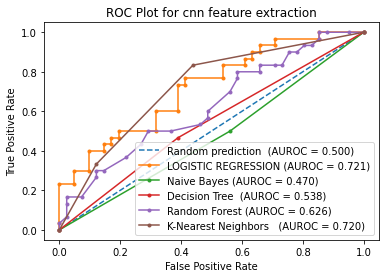

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot the ROC curve
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction  (AUROC = %0.3f)' % r_auc)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='LOGISTIC REGRESSION (AUROC = %0.3f)' % logistic_auc)
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % gnb_auc)
plt.plot(DTC_fpr, DTC_tpr, marker='.', label='Decision Tree  (AUROC = %0.3f)' % DTC_auc)
plt.plot(RFC_fpr, RFC_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % RFC_auc)
plt.plot(neigh_fpr, neigh_tpr, marker='.', label='K-Nearest Neighbors   (AUROC = %0.3f)' % neigh_auc)

# Title
plt.title('ROC Plot for cnn feature extraction')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()
plt.savefig('ROC curve for cnn feature extraction')